In [34]:
from PIL import Image
from dask import delayed
import numpy as np
import math
import cv2

import glob
from scipy import ndimage
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import ndimage as ndi
import scipy.misc
from skimage import exposure
import os 
import multiprocessing
#from dask.distributed import Client, progress
import dask.array as da
#import dask_ndmeasure
import dask
import dask.threaded
from scipy.ndimage.measurements import center_of_mass
from scipy.optimize import linear_sum_assignment
from scipy.spatial import distance
import scipy.linalg as sla
from dask.multiprocessing import get as mp_get
#from dask_ml.cluster import SpectralClustering


In [35]:
global sigma1
global kernel_size 
global weak_pixel
global strong_pixel

sigma1=1
kernel_size=5
weak_pixel=75
strong_pixel=255
 

def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g

def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)

    Ix = ndimage.filters.convolve(img, Kx)
    Iy = ndimage.filters.convolve(img, Ky)

    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    return (G, theta)


def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180


    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255

               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0


            except IndexError as e:
                pass

    return Z

def threshold(img, highThreshold, lowThreshold):

    highThreshold = img.max() * highThreshold;
    lowThreshold = highThreshold * lowThreshold;

    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)

    weak = np.int32(weak_pixel)
    strong = np.int32(strong_pixel)

    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)

    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))

    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak

    return (res)

def hysteresis(img):

    M, N = img.shape
    weak = weak_pixel
    strong = strong_pixel

    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass

    return img

In [36]:
def visualize2(imgs, im_name='vis.png', format=None, gray=False):
    plt.figure(figsize=(20, 50))
    for i, img in enumerate(imgs):
#         if img.shape[0] == 3:
#             img = img.transpose(1,2,0)
        plt_idx = i+1
        plt.subplot(20, 5, plt_idx)
        plt.imshow(img, cmap = format)
        plt.grid(False)
        plt.colorbar()
    plt.savefig(im_name)
    #print (plt_idx)  
    plt.show()

In [37]:
def visualize3(imgs, im_name='vis.png', format=None, gray=False):
    plt.figure(figsize=(20, 20))
    for i, img in enumerate(imgs):
#         if img.shape[0] == 3:
#             img = img.transpose(1,2,0)
        plt_idx = i+1
        plt.subplot(3, 3, plt_idx)
        plt.imshow(img, cmap = format)
        plt.grid(False)
        plt.colorbar()
    plt.savefig(im_name)
    #print (plt_idx)  
    plt.show()

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)

In [39]:
def colorit(image, cmap='seismic'):
    cm = plt.get_cmap(cmap)
    colored_image = cm(image/np.max(image))
    colored_image = (colored_image[:, :, :3] * 255).astype(np.uint8)
    return colored_image

In [40]:
def normalization(img):
    v = img
    return (v - v.min()) / (v.max() - v.min())

In [41]:
file = '/Users/mojtaba/Downloads/problem2_beatingcardiomyocytes.tif'

from tifffile import imread
series = imread(file)
series.shape

(500, 1023, 1023)

In [42]:
images = series
normed_images = np.array([normalization(images[i]) for i in range(len(images))])


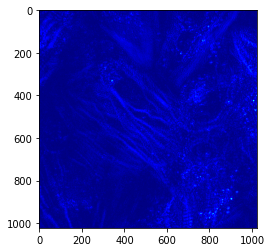

In [44]:
plt.imshow(normed_images[0, :, :], cmap='jet')
plt.show()


In [45]:

np.min(normed_images[0]), np.max(normed_images[0])
normed_images_255 = np.array([im*255 for im in normed_images])
normed_images_255[0]

array([[3.3291576, 2.4700599, 3.5706122, ..., 3.4520903, 1.2508905,
        2.472999 ],
       [5.2923255, 3.7418265, 4.9125996, ..., 3.155078 , 2.152131 ,
        2.9608505],
       [6.91534  , 4.811585 , 5.0484657, ..., 2.6843708, 0.4398863,
        1.5486205],
       ...,
       [2.5474946, 5.0136585, 7.426347 , ..., 2.5810928, 4.377331 ,
        3.2113974],
       [2.9727387, 6.440417 , 9.210895 , ..., 2.1113632, 4.954488 ,
        2.2764404],
       [2.8951511, 5.195363 , 5.082341 , ..., 2.0117795, 2.263841 ,
        2.1748204]], dtype=float32)

In [46]:
def numpy2mp4(data, filepath, dsize1, dsize2):
    data_res= np.array([cv2.resize(img, dsize1, interpolation=cv2.INTER_CUBIC) for img in data])
    v = cv2.VideoWriter(filepath, fourcc = cv2.VideoWriter_fourcc(*'x264'), isColor= False, fps= 15.15,apiPreference=cv2.CAP_FFMPEG, frameSize= dsize1)
    for datum in data_res:
        v.write(np.uint8(datum))
    v.release()

#### First, let me create videos from the tif images to inspire from them and understand the problem. For that I used the same function of problem1 that can convert the numpy array into an MP4 video file. Also the video size was a bit large, thus, I resized it. 

In [47]:
output_path='/Users/mojtaba/Downloads/exercise_RnDEng_2021/videos/'
dsize1= (400, 400)
dsize2= (1023, 1023)


vid= normed_images_255

numpy2mp4(vid, output_path+'problem2_video_2.mp4', dsize1, dsize2)

vid.shape

(500, 1023, 1023)

Let's See how the video looks like:

In [48]:
from IPython.display import HTML
from base64 import b64encode

def play(filename):
    html = ''
    video = open(filename,'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html += '<video width=300 controls autoplay loop><source src="%s" type="video/mp4"></video>' % src 
    return HTML(html)

play('/Users/mojtaba/Downloads/exercise_RnDEng_2021/videos/problem2_video_2.mp4')
#play('/Users/mojtaba/Downloads/exercise_RnDEng_2021/videos/video3.mp4')

In [49]:
vid[0].min(), vid[1].max()

(0.0, 255.0)

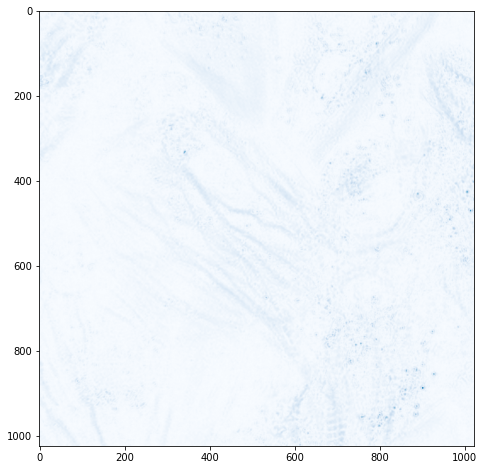

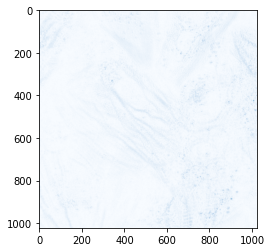

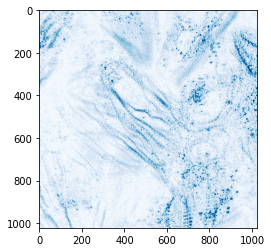

In [52]:
test_img = images[0]
test_img_normed = normalization(test_img)    
# normalize float versions
norm_img1 = cv2.normalize(test_img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
norm_img1 = (255*norm_img1).astype(np.uint8)


normed2 = [cv2.normalize(test_img, None, alpha=0, beta=5.25, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F) for test_img in images]
# scale to uint8

norm_img2 = [np.clip(n, 0, 1) for n in normed2]

# display input and both output images

plt.imshow(test_img, cmap='Blues')
plt.show()
plt.imshow(norm_img1, cmap='Blues')
plt.show()
plt.imshow(norm_img2[0], cmap='Blues')
plt.show()

In [53]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure(figsize =(24, 8))
va1s = norm_img2
xx1, yy1 = np.mgrid[0:norm_img2[0].shape[0], 0:norm_img2[0].shape[1]]
xva1, yva1 = np.mgrid[0:np.array(va1s).shape[0], 0:np.array(va1s).shape[1]]



In [54]:

val_255 = [(255*a).astype(np.uint8) for a in norm_img2]
val_255 = np.array(val_255)
np.min(val_255), np.max(val_255), val_255.shape

(0, 255, (500, 1023, 1023))

## Problem 2/ 

#### Part A) Map of the direction of movement of myofibrils and other cell components.

For that, We can use optical flow to find directionality in both Dense and sparse forms. For the dense one, I used dense optical flow arrows. For the sparse one also I created a salient feature tracking method in order to track the most important features of the video. The merits of tracking based method relies in the fact that we can examine each desired part of the image individually.  

In [55]:
from pathlib import Path
import numpy as np
import cv2 as cv
from PIL import Image
import matplotlib.pyplot as plt

frame_1, frame_2= val_255[0], val_255[1]

In [56]:
flow = cv2.calcOpticalFlowFarneback(np.array(frame_1), 
                                   np.array(frame_2), 
                                   None, 0.5, 3, 15, 3, 5, 1.2, 0)

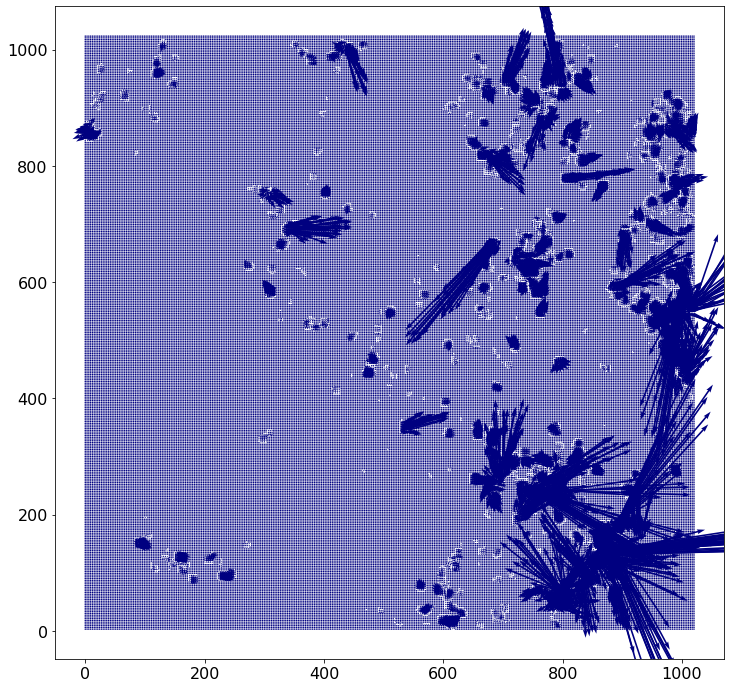

In [77]:
fig = plt.figure(figsize =(12, 12))
step = 3
plt.quiver(np.arange(0, flow.shape[1], step), np.arange(flow.shape[0], -1, -step)[:-1], 
           flow[::step, ::step, 0], flow[::step, ::step, 1], color='Navy', cmap='hot')
plt.show()

In [57]:
# import cv2
# import numpy as np
# frames = []
# # Create a VideoCapture object and read from input file
# # If the input is the camera, pass 0 instead of the video file name
# cap = cv2.VideoCapture('/Users/mojtaba/Downloads/Harvard/gl_progress3-2.mp4')
# X = int(cap.get(3))
# Y = int(cap.get(4))
# # Check if camera opened successfully
# if (cap.isOpened()== False): 
#     print("Error opening video stream or file")

# # Read until video is completedq
# while(cap.isOpened()):
#     # Capture frame-by-frame
#     ret, frame = cap.read()
#     if ret == True:

#     # Display the resulting frame
#         frames.append(frame)
#     else: 
#         break

# # When everything done, release the video capture object
# cap.release()

# # # Closes all the frames
# cv2.destroyAllWindows()
# # width, height = np.array(frames).size
# np.array(frames).shape, X, Y

In [58]:
#frames = frames[110:450]

/Users/mojtaba/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  


(500, 1023, 1023)
(500, 1023, 1023)


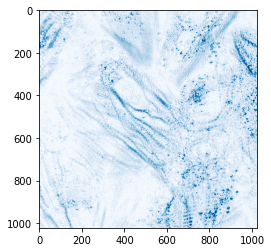

In [61]:
import matplotlib.pyplot as plt

from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

image_bw = np.array([color.rgb2gray(frame) for frame in val_255])
print(image_bw.shape)

image_rescaled = np.array([rescale(img, 1., anti_aliasing=False) for img in image_bw])
print(image_rescaled.shape)
plt.imshow(image_rescaled[2], cmap='Blues')
plt.show()

In [62]:
len(image_rescaled)-1

499

63


/Users/mojtaba/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Passing the sharex parameter of subplots() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


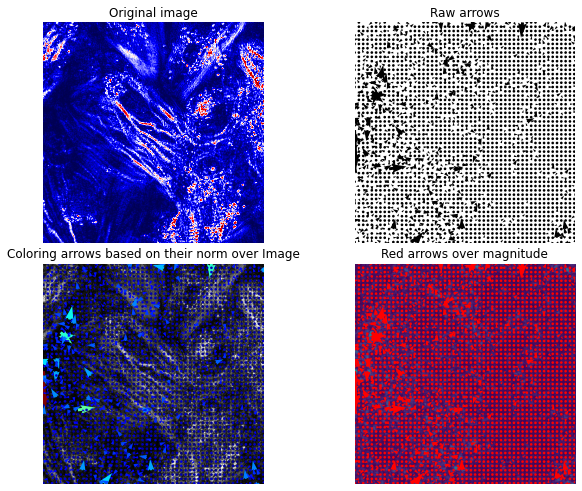

64


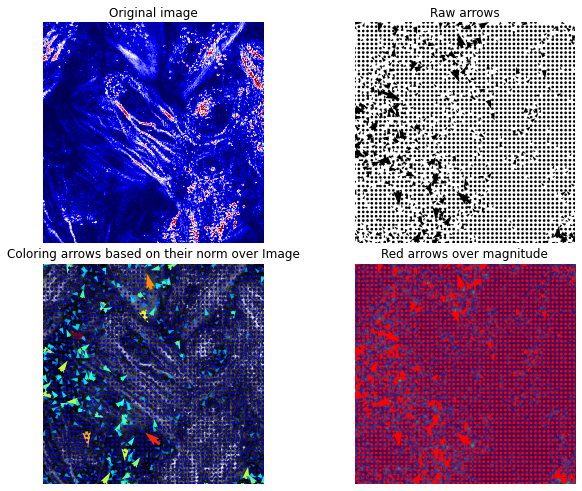

0

In [66]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pyimof


# --- Load the MiniCooper sequence
# frame_1 = images[31]
# frame_2 = images[32]
# I0, I1 = frame_1, frame_2

for i in range(63, 65):#len(image_rescaled)-1):#len(images)-1):
    plt.ioff()
    print(i)
# Estimate the optical flow
    I0, I1= image_rescaled[i], image_rescaled[i+1]
    u, v = pyimof.solvers.ilk(I0, I1)
    norm = np.sqrt(u*u + v*v)

# Display 

    fig = plt.figure(figsize=((9, 7)))
    ax0, ax1, ax2, ax3 = fig.subplots(2, 2, True, True).ravel()
    fig.tight_layout()

    ax0.imshow(I0, cmap='seismic')
    ax0.set_axis_off()
    ax0.set_title("Original image")

    pyimof.display.quiver(u, v, ax=ax1)
    ax1.set_title("Raw arrows")

    pyimof.display.quiver(u, v, c=norm, bg=I0, ax=ax2,
                          cmap='jet', bg_cmap='gray')
    ax2.set_title("Coloring arrows based on their norm over Image")

    pyimof.display.quiver(u, v, bg=norm, ax=ax3, color='r')
    ax3.set_title("Red arrows over magnitude")
    plt.savefig('4xcontourff%04d.jpg' % i, dpi=400, bbox_inches='tight')
    plt.pause(0.001)

import os
os.system("ffmpeg -r 5 -i 4xcontourff%04d.jpg -vcodec mpeg4 -y Gl_progression.mp4")    
    



In [10]:
save('xcontourff', '3dtrajectory.mp4')

'3dtrajectory.mp4)' was not found in history, as a file, url, nor in the user namespace.


We also can use sparse optical flow for feature tracking. I've done that and put the code into src folder. Here you can see the outputs of that code:


# Tracking Results:

In [69]:
play('/Users/mojtaba/Desktop/N/exercise_RnDEng_2021/videos/Problem_2_Enhanced_trackingVideo.avi')

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Trajectories of the tracked points results:

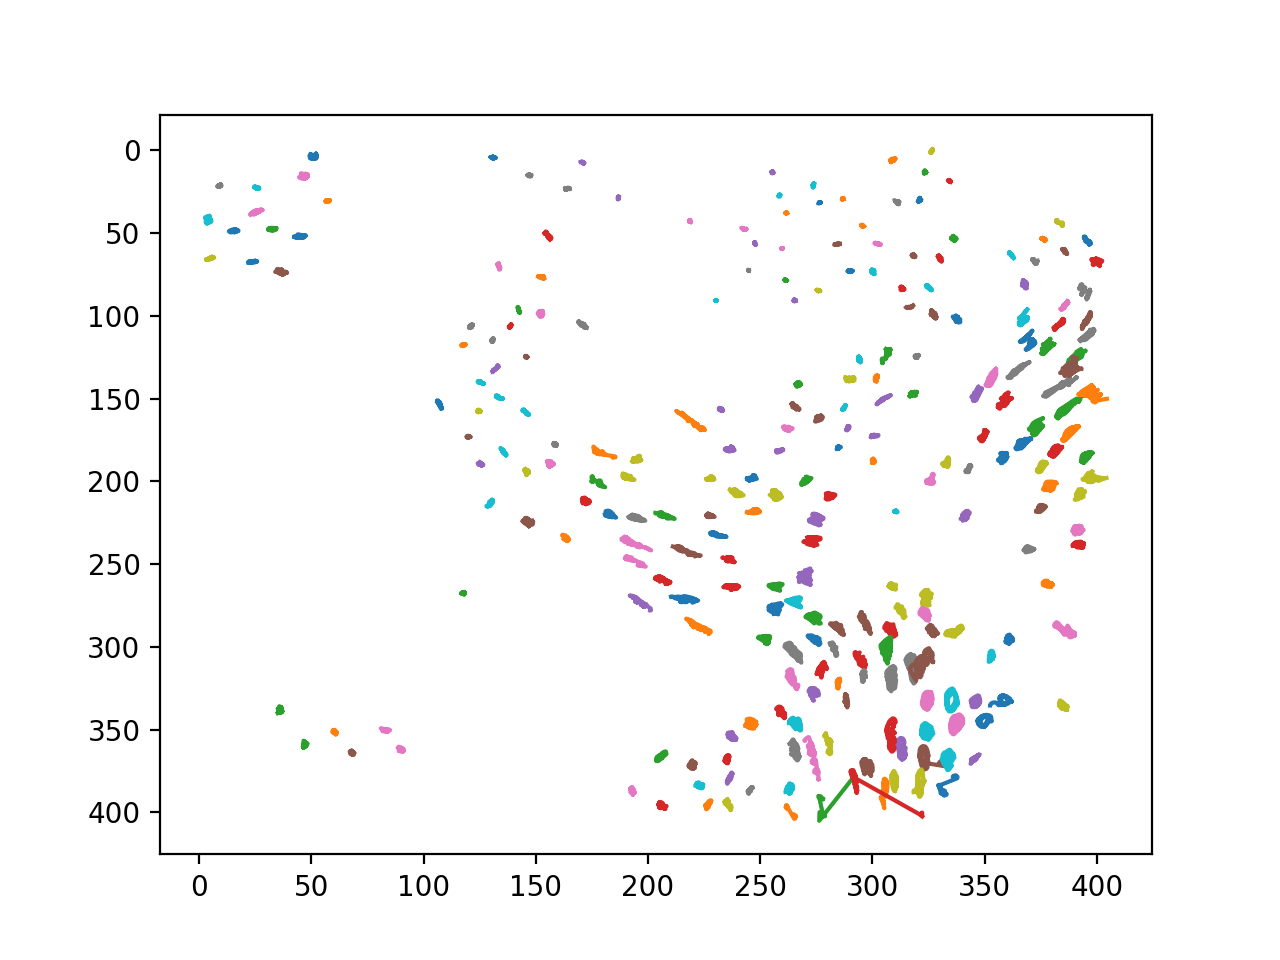

In [71]:
from IPython.display import Image
Image(filename='/Users/mojtaba/Desktop/N/exercise_RnDEng_2021/figures/Figure_1.png')

In [13]:
play('/Users/mojtaba/Desktop/N/3dtrajectory.mp4')

NameError: name 'play' is not defined

Average intensity of the the whole image indicates somehow the pulses because the intensity of image is changing by each beat. 

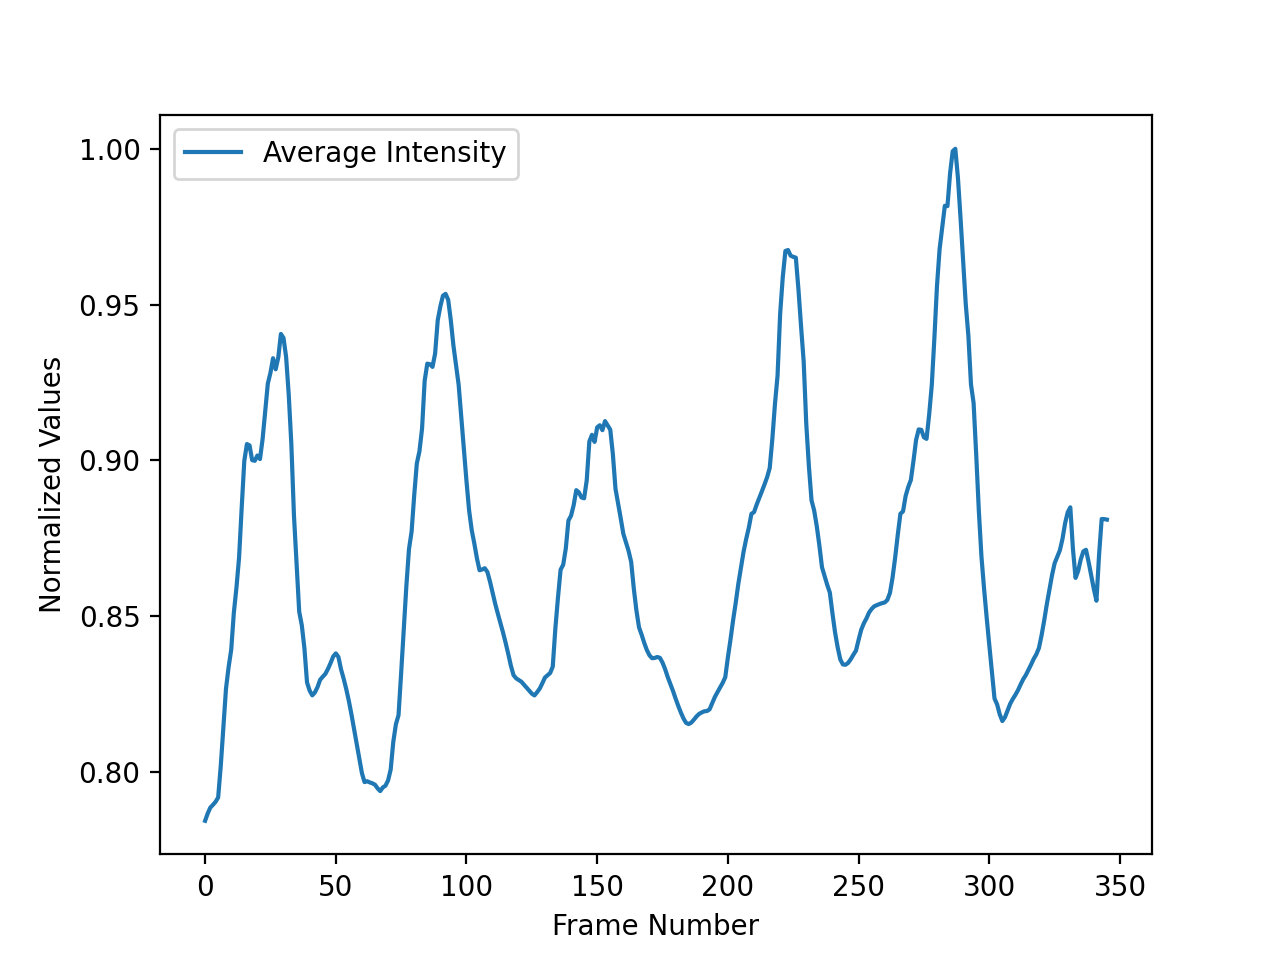

In [72]:
Image(filename='/Users/mojtaba/Desktop/N/exercise_RnDEng_2021/figures/Figure_2.png')

Now We Assume the speed of point number 0 and the interesting following plots indicates the speed of beating in that point:

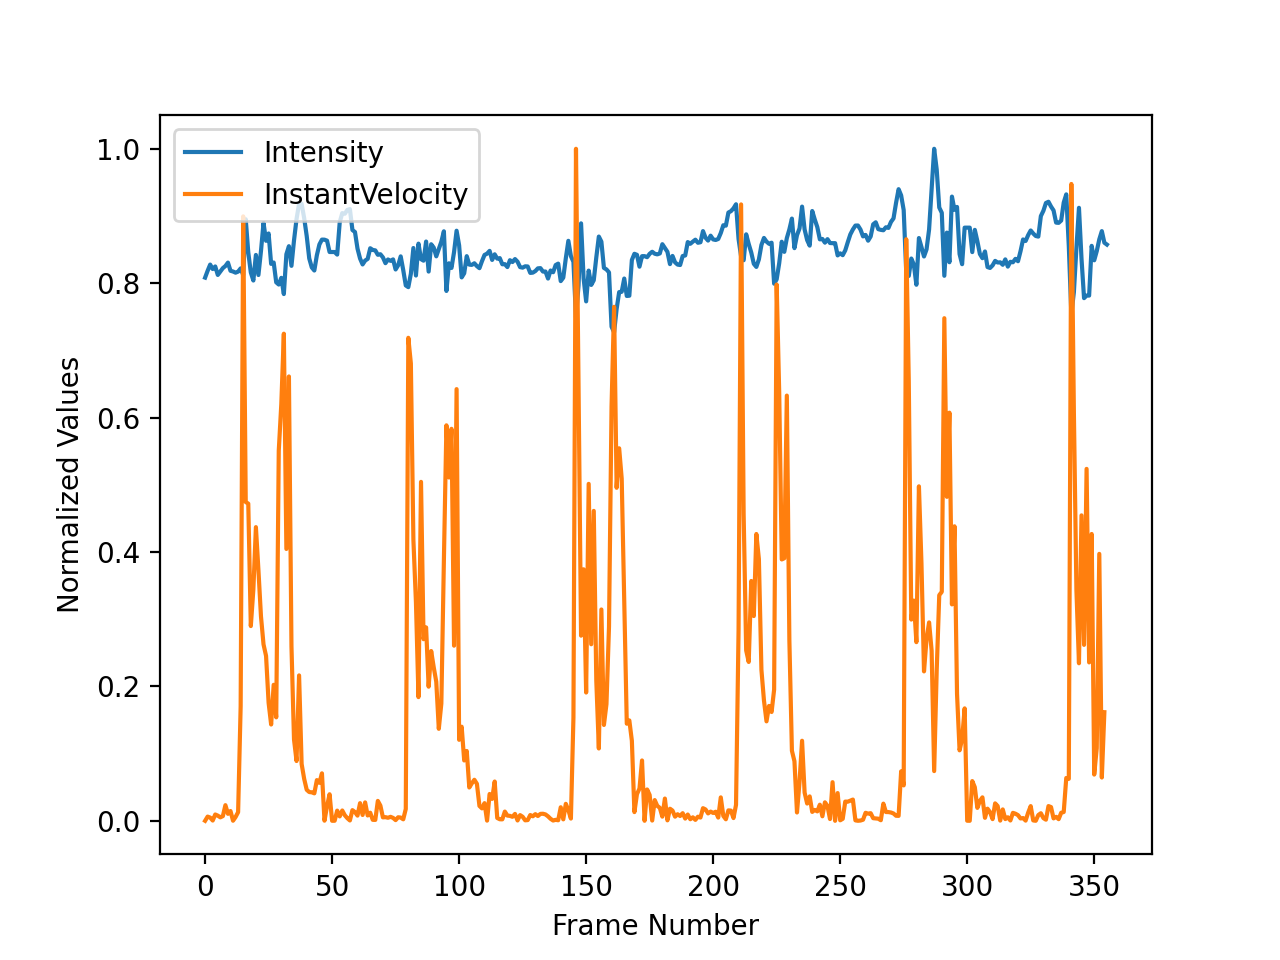

In [73]:
Image(filename='/Users/mojtaba/Desktop/N/exercise_RnDEng_2021/figures/Figure_3.png')

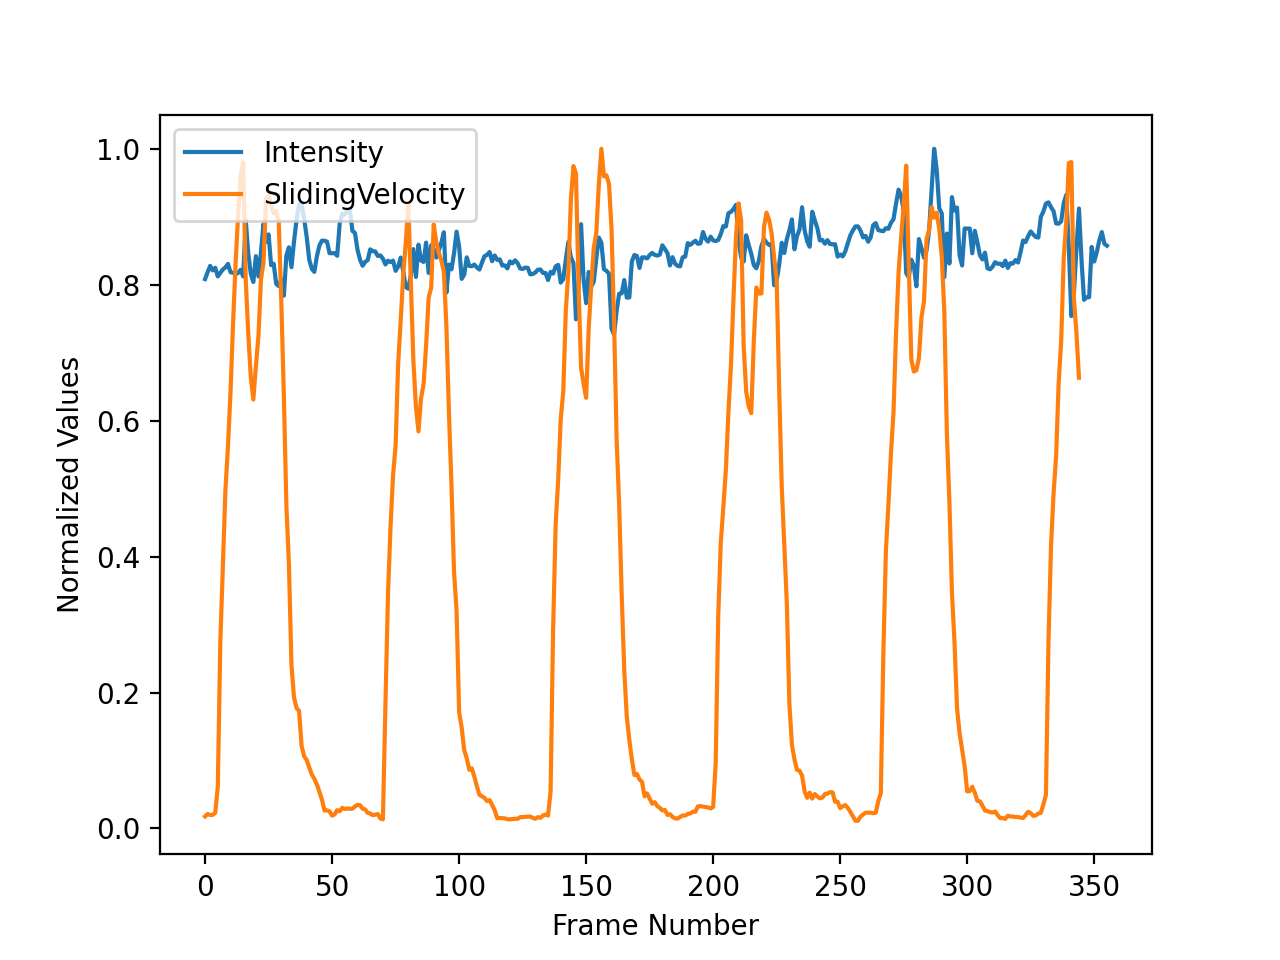

In [74]:
Image(filename='/Users/mojtaba/Desktop/N/exercise_RnDEng_2021/figures/Figure_4.png')

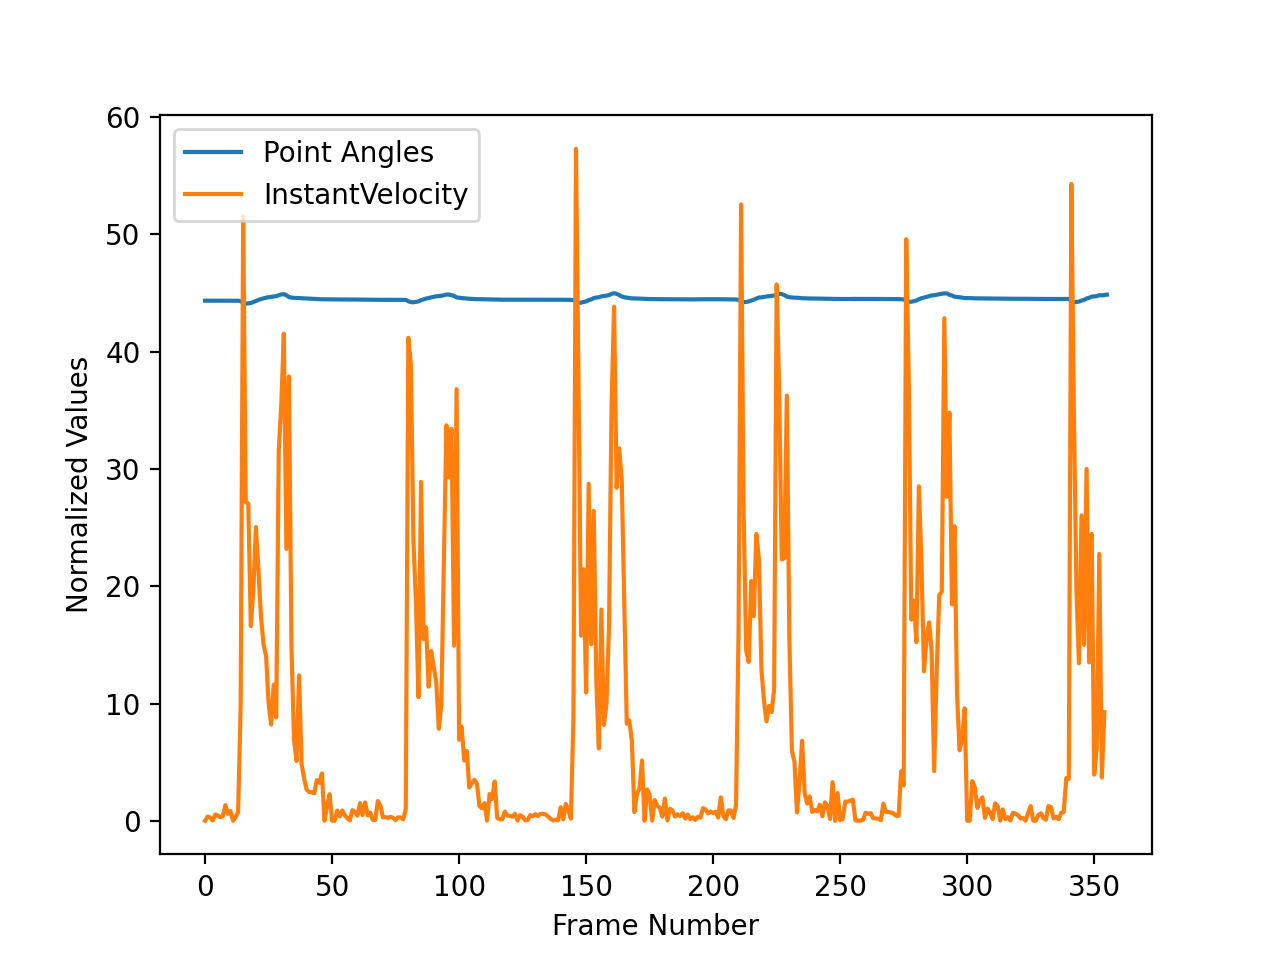

In [75]:
Image(filename='/Users/mojtaba/Desktop/N/exercise_RnDEng_2021/figures/Figure_5.png')

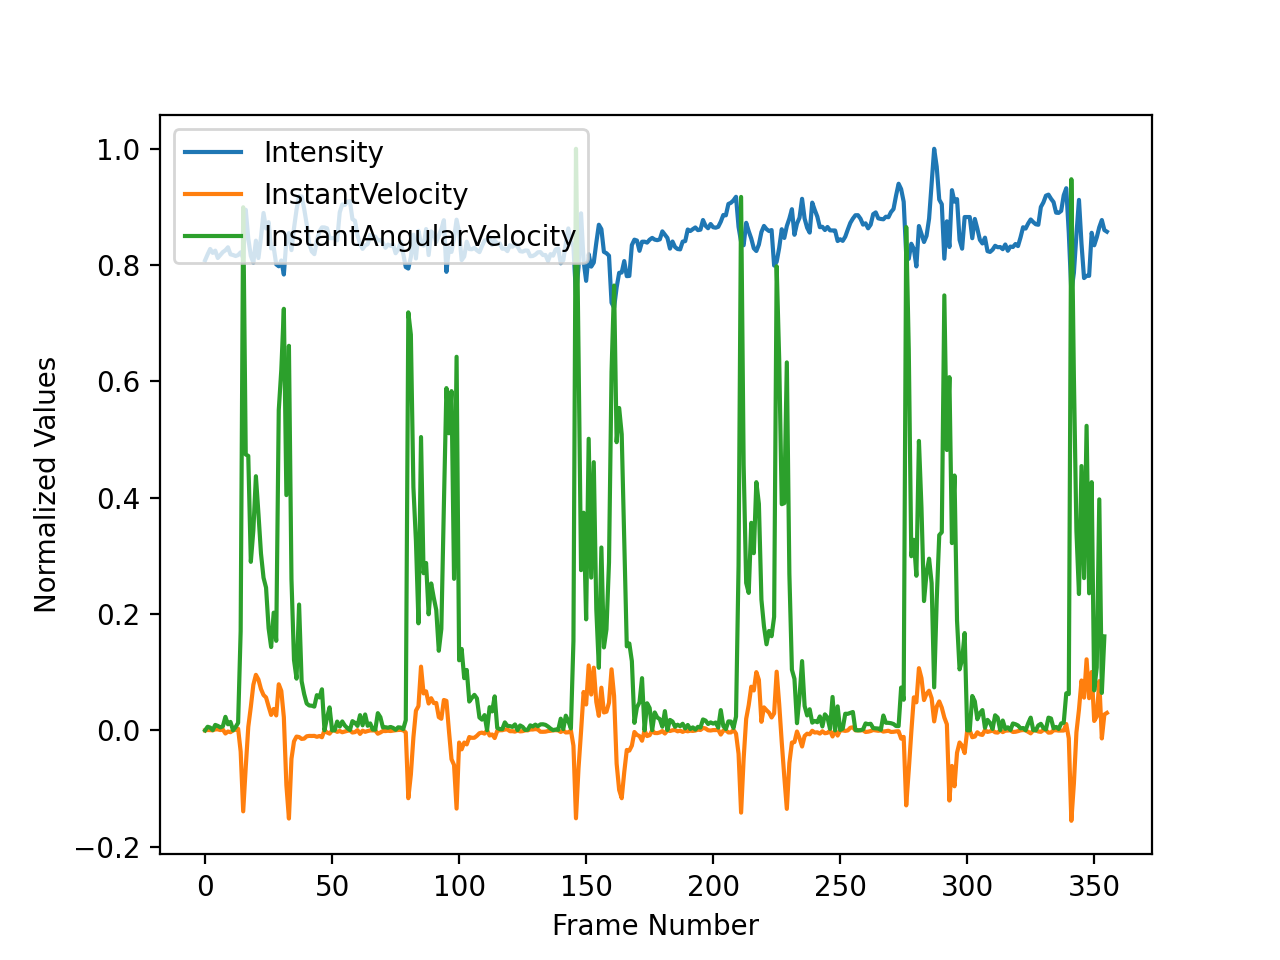

In [76]:
Image(filename='/Users/mojtaba/Desktop/N/exercise_RnDEng_2021/figures/Figure_6.png')

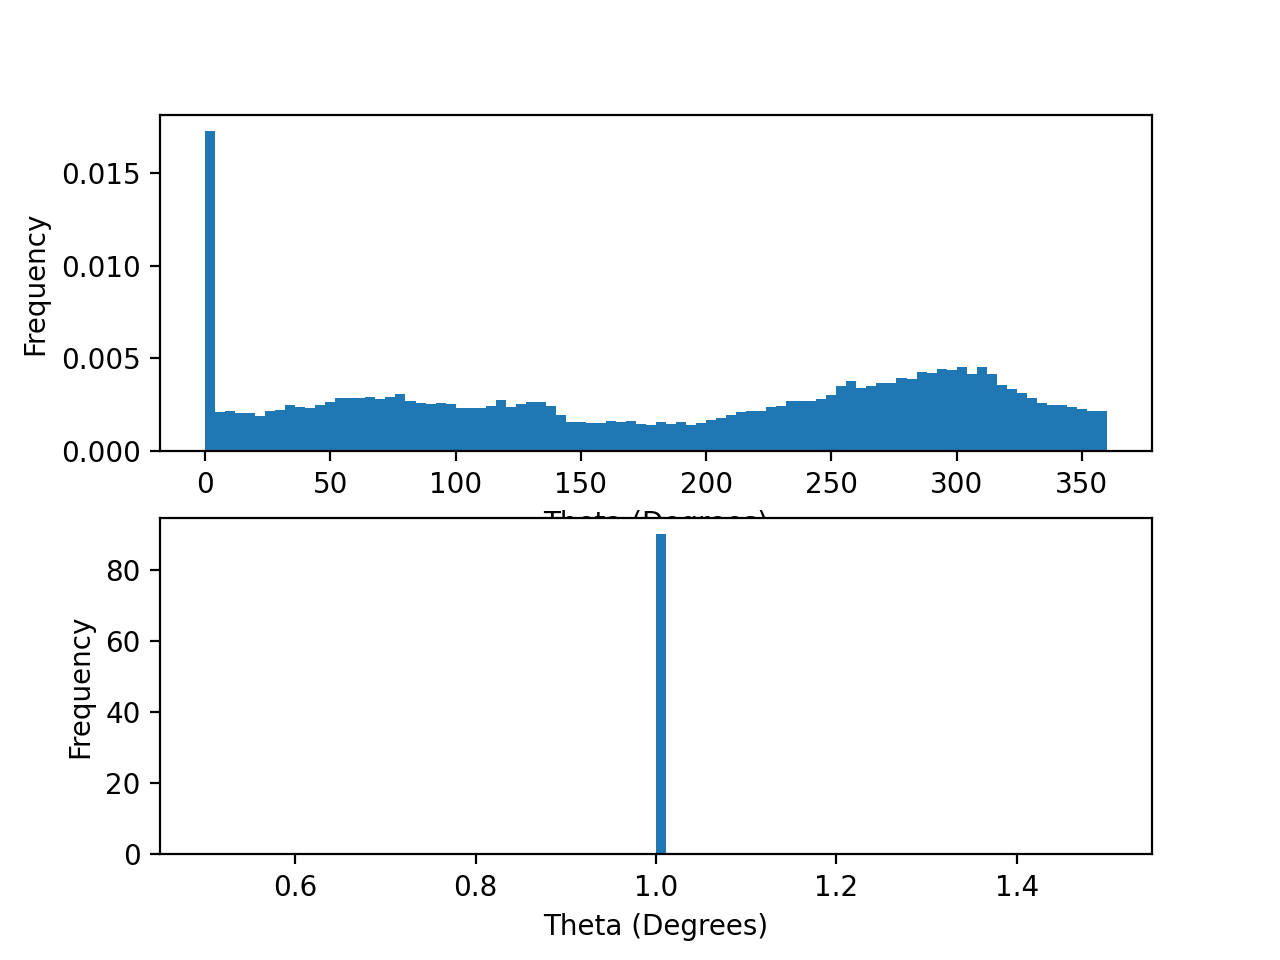

In [77]:
Image(filename='/Users/mojtaba/Desktop/N/exercise_RnDEng_2021/figures/Figure_8.png')

I also computed the histogram of angles of the motility to see the differences in motility directions:

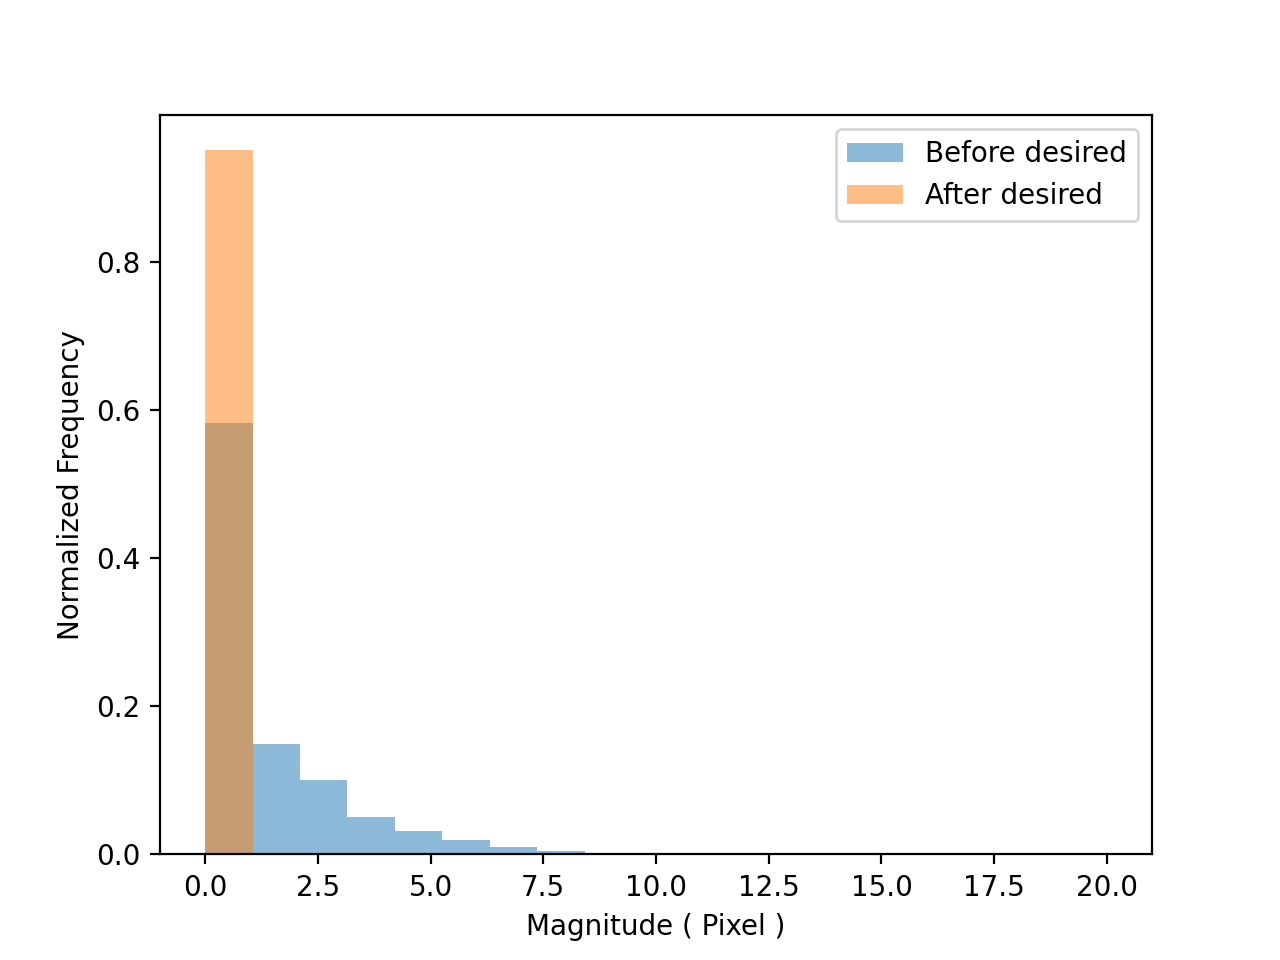

In [78]:
Image(filename='/Users/mojtaba/Desktop/N/exercise_RnDEng_2021/figures/Figure_10.png')

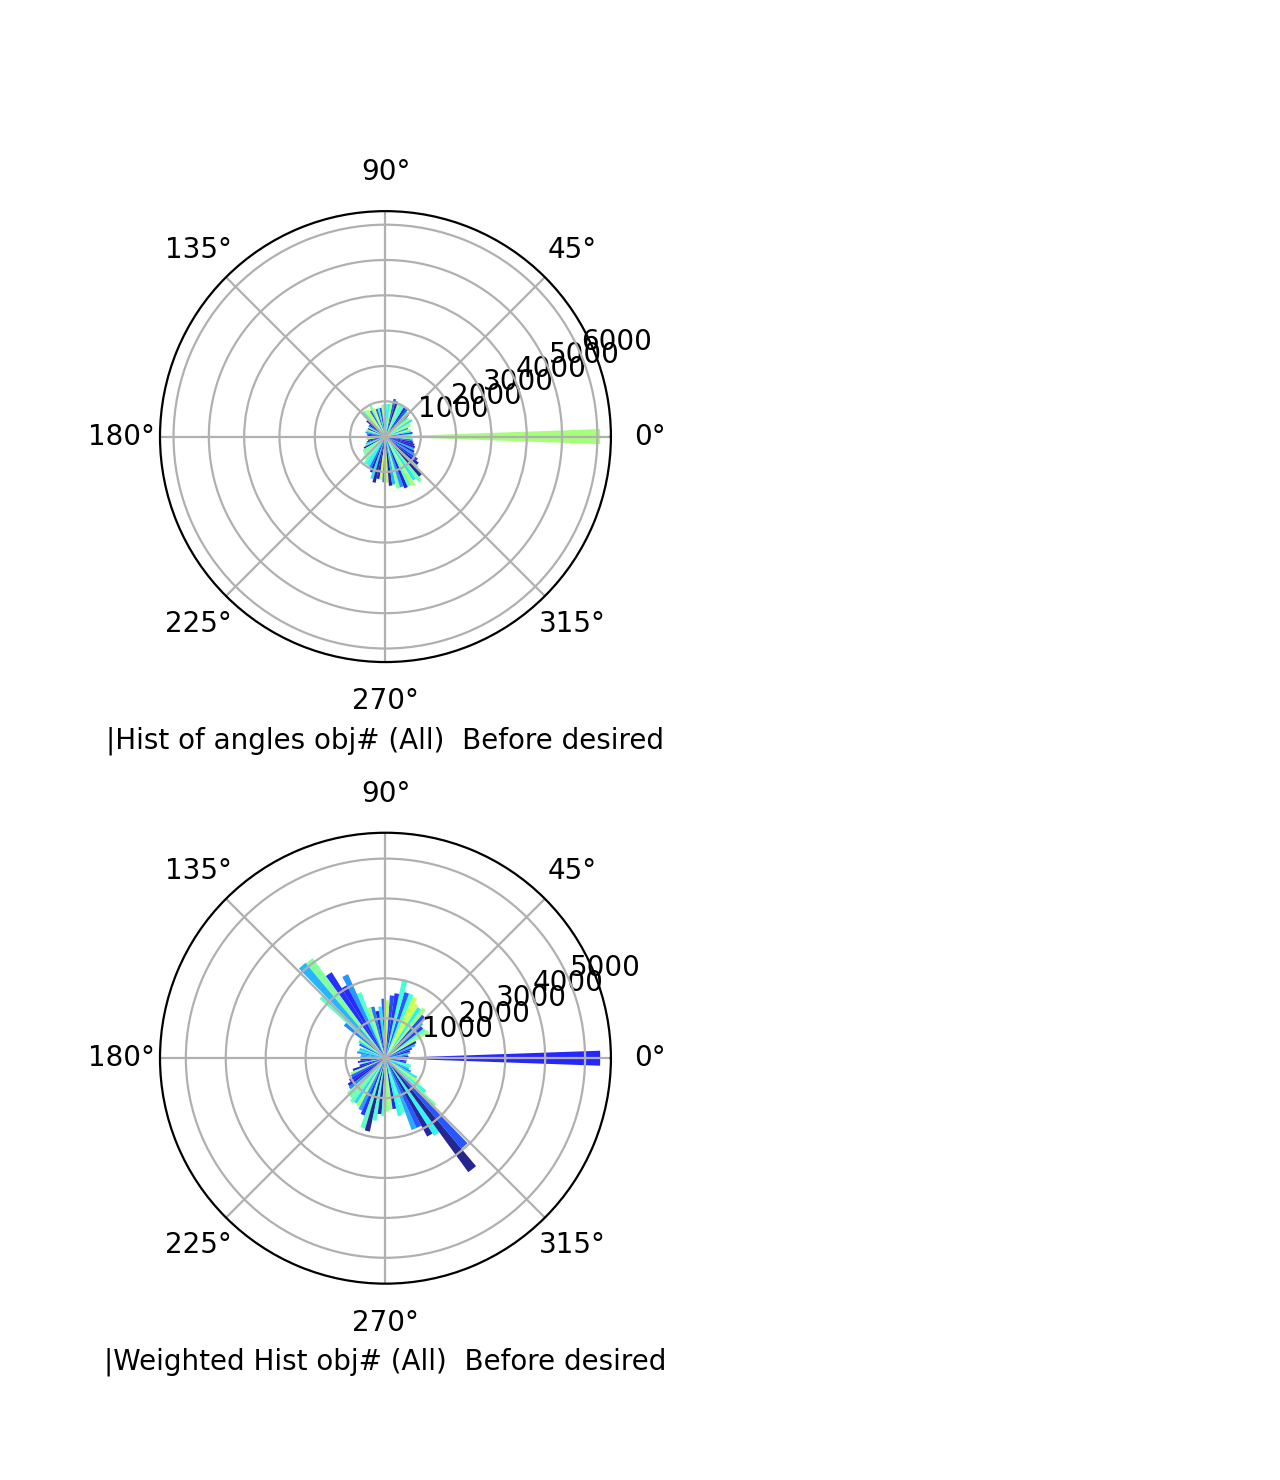

In [79]:
Image(filename='/Users/mojtaba/Desktop/N/exercise_RnDEng_2021/figures/Figure_12.png')

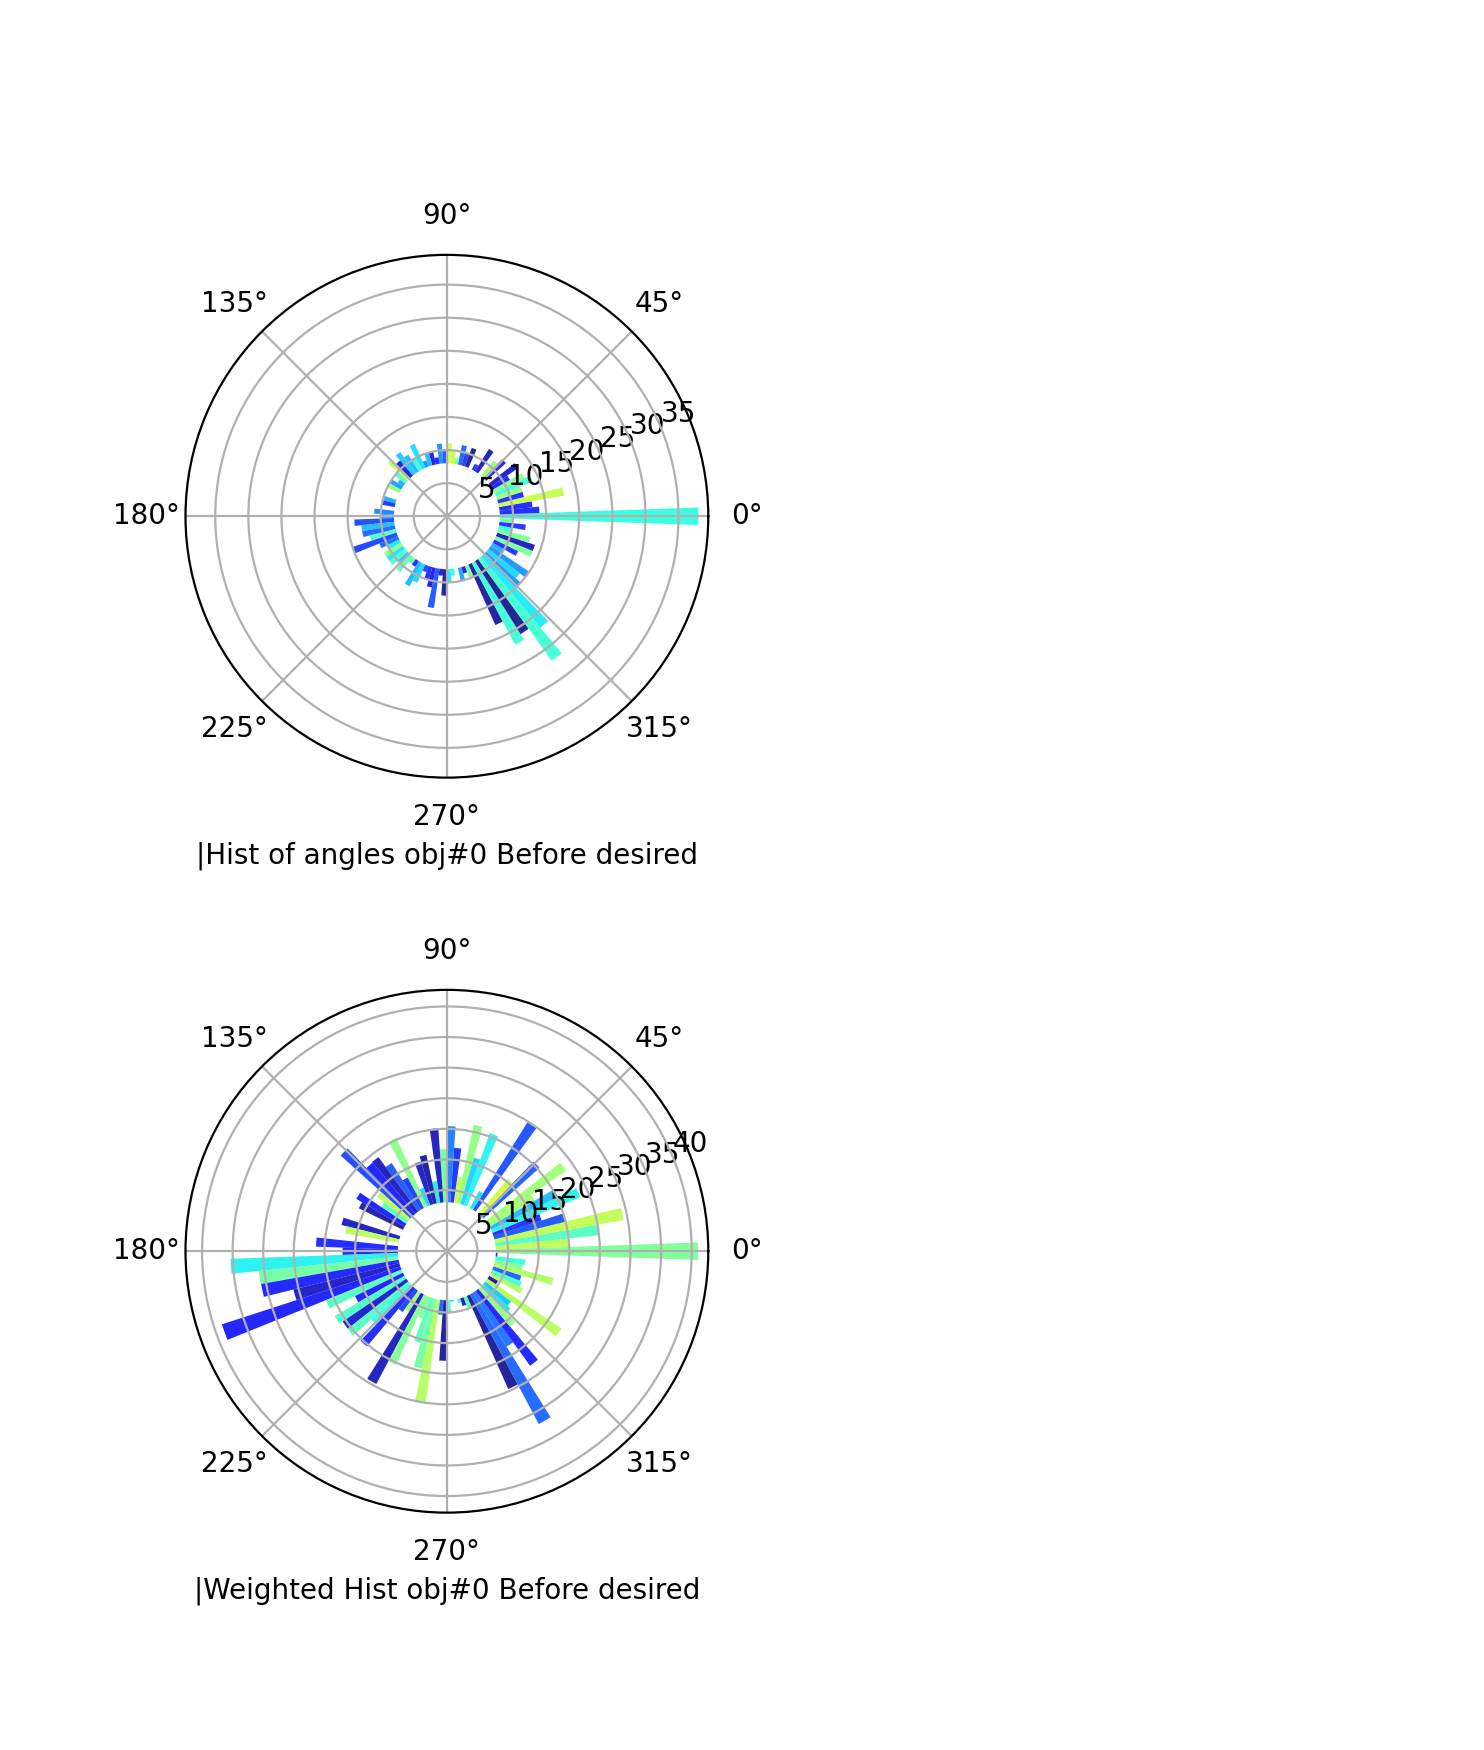

In [80]:
Image(filename='/Users/mojtaba/Desktop/N/exercise_RnDEng_2021/figures/Figure_13.png')


#### Part B) Map of the direction of movement of myofibrils and other cell components.

In [ ]:
# Get a VideoCapture object from video and store it in vс
vid = '/Users/mojtaba/Downloads/exercise_RnDEng_2021/videos/problem2_video_2.mp4'


import cv2
import numpy as np

# Get a VideoCapture object from video and store it in vs
vc = cv2.VideoCapture(vid)
ret, first_frame = vc.read()
resize_dim = 600
max_dim = max(first_frame.shape)
scale = resize_dim/max_dim
first_frame = cv2.resize(first_frame, None, fx=scale, fy=scale)
prev_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)


# Create mask
mask = np.zeros_like(first_frame)
mask[..., 1] = 255


out = cv2.VideoWriter('video.mp4',-1,1,(600, 600))

while(True):
    ret, frame = vc.read()
    
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, None, fx=scale, fy=scale)

    flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, None, pyr_scale = 0.2, levels = 5, winsize = 9, iterations = 4, poly_n = 5, poly_sigma = 1.1, flags = 0)
    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    mask[..., 0] = angle * 180 / np.pi / 2
    mask[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)

    rgb = cv2.cvtColor(mask, cv2.COLOR_HSV2BGR)
    frame = cv2.resize(frame, None, fx=scale, fy=scale)
    dense_flow = cv2.addWeighted(frame, 1,rgb, 2, 0)
    cv2.imshow("Dense optical flow", dense_flow)
    out.write(dense_flow)
    prev_gray = gray
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
vc.release()

cv2.destroyAllWindows()

In [81]:
import matplotlib.patches as patches

def plot_big2(x, w=8.5, h=6):
    fig, ax = plt.subplots(1)    # Create a Rectangle patch
    ax.imshow(x, cmap='gray')

    rect1 = patches.Rectangle((440,440),230, 230,linewidth=1,edgecolor='r',facecolor='none')
    rect2 = patches.Rectangle((520,30),230,230,linewidth=1,edgecolor='lime',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect1)
    ax.add_patch(rect2)
    fig.set_size_inches(w, h)
    plt.title('A patch of myofibrils cells VS a patch of other cells')
    plt.show()

<Figure size 864x864 with 0 Axes>

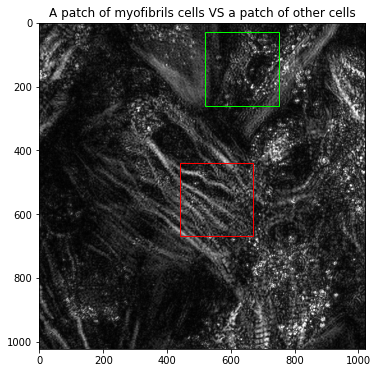

In [82]:
plt.figure(figsize=(12, 12))
plot_big2(val_255[0])
#plot_big2(normed_images[0])


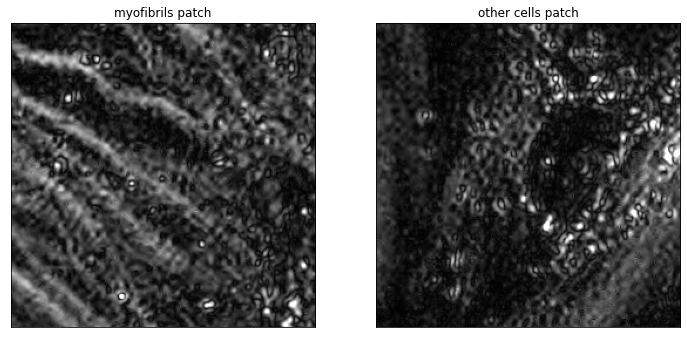

In [83]:
# ((440,440),200, 200
# ((520, 30),200, 200

 
plt.figure(figsize=(12, 12))

plt.subplot(121), plt.imshow(val_255[0, 440:700, 440:700], cmap='gray'), plt.title('myofibrils patch')
plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(val_255[0, 30:290, 520:780], cmap='gray'), plt.title('other cells patch')
plt.xticks([]), plt.yticks([])
plt.show()

In [84]:
fibro_patch = val_255[:, 440:700, 440:700]
other_patch = val_255[:, 30:290, 520:780]
fibro_patch.shape, np.min(fibro_patch[0]), np.max(fibro_patch[0])

((500, 260, 260), 0, 255)

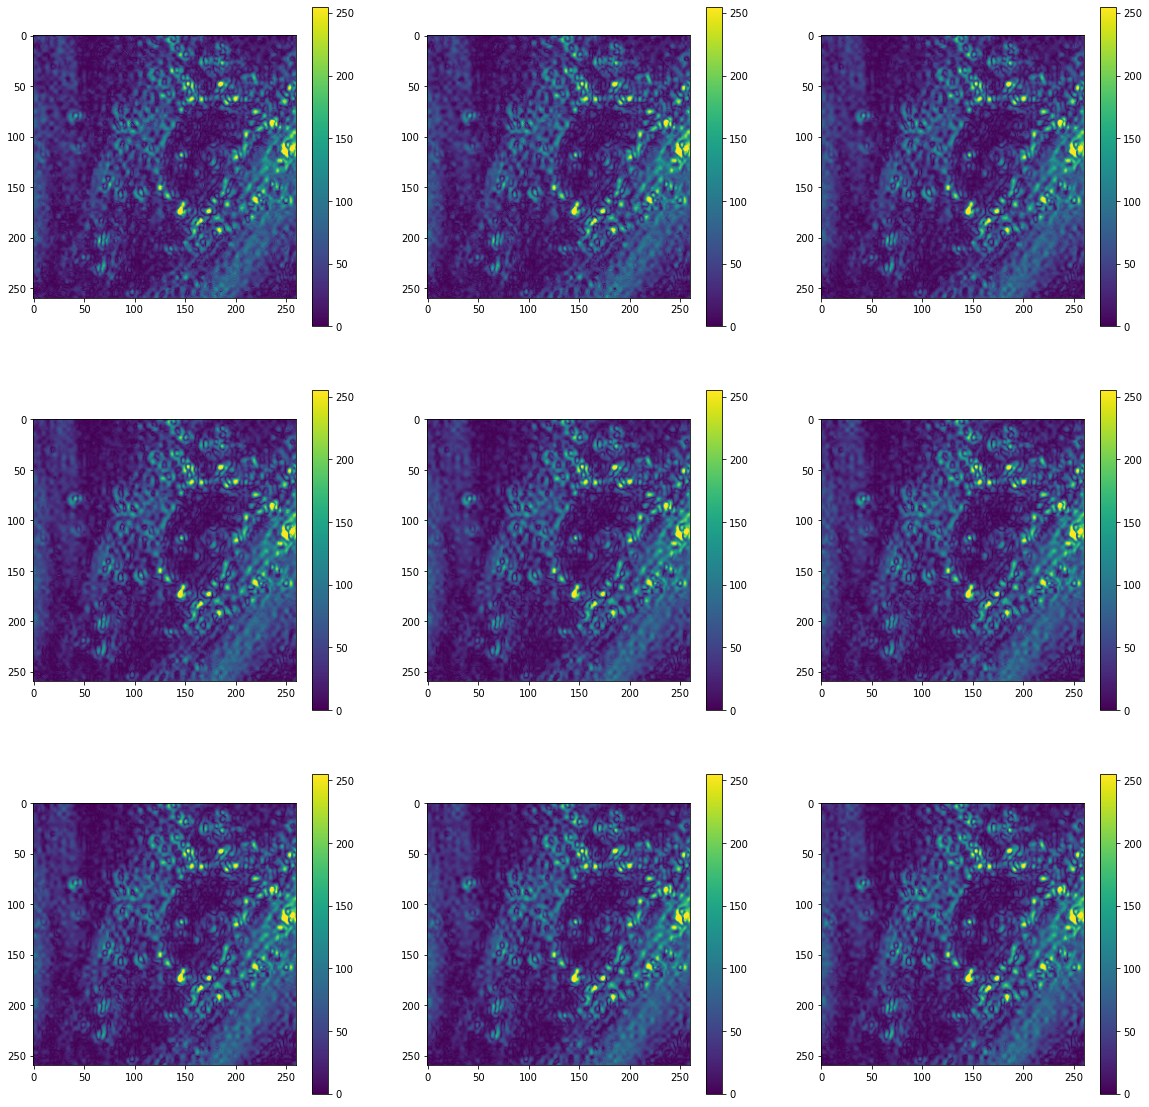

In [85]:
visualize3(other_patch[:9])

In [86]:
fibro_patch[0].shape

(260, 260)

In [87]:
output_path='/Users/mojtaba/Downloads/exercise_RnDEng_2021/videos/'
dsize1= fibro_patch[0].shape
dsize2= fibro_patch[0].shape


vid= fibro_patch
vid2= other_patch
numpy2mp4(vid, output_path+'fibro_patch_video_2.mp4', dsize1, dsize2)
numpy2mp4(vid2, output_path+'other_patch_video_2.mp4', dsize1, dsize2)


# npy2mp4(fibro_patch,output_path+'p2_fibro_patch2.mp4')
# npy2mp4(other_patch,output_path+'p2_other_patch2.mp4')
# npy2mp4(normed_images,output_path+'p2_normed_images2.mp4')

In [88]:
def get_optical_flow(video_filename):
    """ Given a video filename, returns dx's and dy's for each time point"""
    
    mean_dxs = []
    mean_dys = []
    
    frame_num = 0

    cap = cv2.VideoCapture(video_filename)

    ret, frame1 = cap.read()

    prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
    hsv = np.zeros_like(frame1)
    hsv[...,1] = 255

    while(True):
        ret, frame2 = cap.read()
        if not ret:
            break

        nextf = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)

        flow = cv2.calcOpticalFlowFarneback(prvs,nextf, None, 0.5, 3, 15, 3, 5, 1.2, 0)

        prvs = nextf

        dx, dy = np.reshape(np.swapaxes(flow, 0, 2), (2, -1))

        mean_dxs.append(np.mean(dx))
        mean_dys.append(np.mean(dy))

        frame_num += 1
        if frame_num >= len(video_filename): 
            break
    return mean_dxs, mean_dys




In [89]:
def plot_histogram(xs, ys, ticksize=12, fontsize=16, show=True):
    import matplotlib as mpl
    """ Plot a histogram given a numeric vector"""
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    
    font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : fontsize}

    mpl.rc('font', **font)
    
    hist, bins = np.histogram(xs, bins=10)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    ax1.bar(center, hist, align='center', width=width)
    ax1.text(0.55, 0.8,"mean: %.3f" % np.mean(xs), horizontalalignment='left',
             verticalalignment='center', transform = ax1.transAxes)
    ax1.text(0.55, 0.72,"stdev: %.3f" % np.std(xs), horizontalalignment='left',
         verticalalignment='center', transform = ax1.transAxes)
    ax1.set_xlabel("delta x", fontsize=fontsize)
    ax1.set_ylabel("Frequency", fontsize=fontsize)
    ax2.tick_params(axis='both', which='major', labelsize=ticksize)
    
    hist, bins = np.histogram(ys, bins=10)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    ax2.bar(center, hist, align='center', width=width)
    ax2.text(0.55, 0.8,"mean: %.3f" % np.mean(ys), horizontalalignment='left',
             verticalalignment='center', transform = ax2.transAxes)
    ax2.text(0.55, 0.72,"stdev: %.3f" % np.std(ys), horizontalalignment='left',
         verticalalignment='center', transform = ax2.transAxes)
    ax2.set_xlabel("delta y", fontsize=fontsize)
    ax2.tick_params(axis='both', which='major', labelsize=ticksize)

    if show:
        plt.show()
    return f

In [90]:
mdx1, mdy1 = get_optical_flow('/Users/mojtaba/Downloads/exercise_RnDEng_2021/videos/fibro_patch_video_2.mp4')
mdx2, mdy2 = get_optical_flow('/Users/mojtaba/Downloads/exercise_RnDEng_2021/videos/other_patch_video_2.mp4')

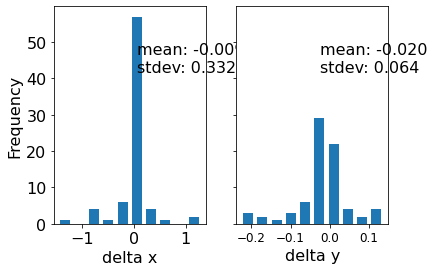

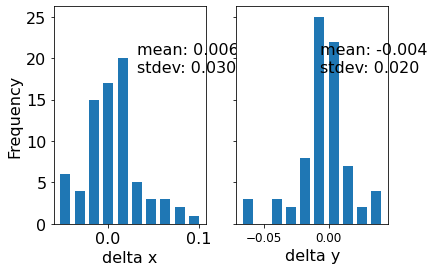

In [92]:
fig = plot_histogram(mdx1, mdy1)
fig = plot_histogram(mdx2, mdy2)

## The above figures indicates cell movement in both X and Y direction in patches that contain Normal and infected cells

/Users/mojtaba/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


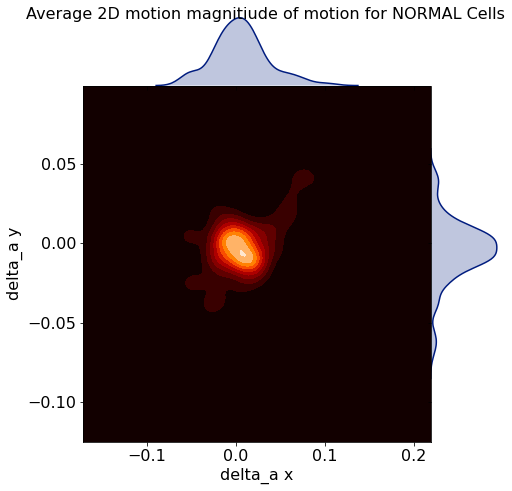

In [93]:
import seaborn as sns
import pandas as pd
# plot one 2D histogram per video
sns.set_palette(sns.color_palette("dark"))

x_a = pd.Series(np.array(mdx1), name="delta_b x")
x_b = pd.Series(np.array(mdx2), name="delta_a x")
y_a = pd.Series(np.array(mdy1), name="delta_b y")
y_b = pd.Series(np.array(mdy2), name="delta_a y")

title='Average 2D motion magnitiude of motion for NORMAL Cells'

#title = fnames[i]
g = sns.jointplot(x_b, y_b, kind="kde", size=7, space=0,
              joint_kws={"cut": 10}, cmap='gist_heat')
g.fig.suptitle(title, size=16)
plt.show()

/Users/mojtaba/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/mojtaba/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


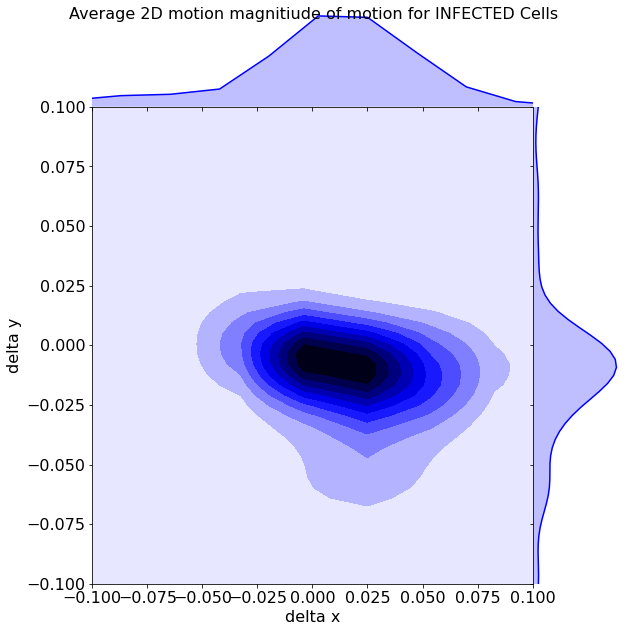

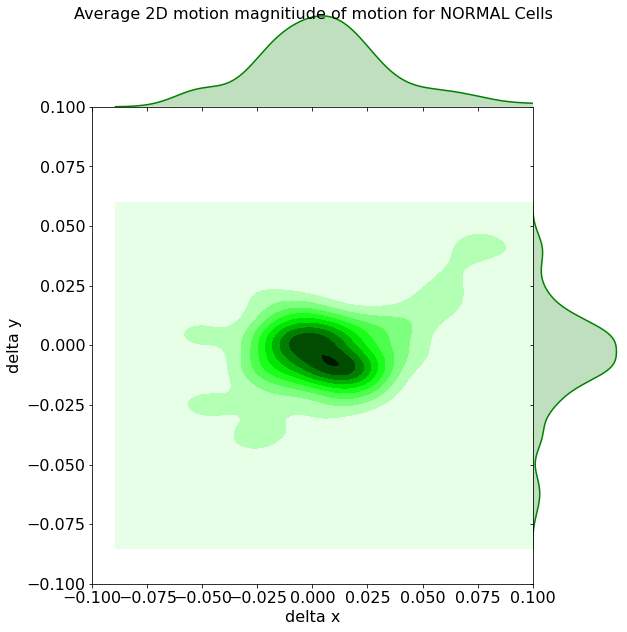

In [94]:
# plot one 2D histogram per video
import seaborn as sns
sns.set_palette(sns.color_palette("dark"))
import pandas as pd

# xs_a.append(mdx1)
# ys_a.append(mdy1)

# xs_b.append(mdx2)
# ys_b.append(mdy2)

x_a = pd.Series(np.array(mdx1), name="delta x")
y_a = pd.Series(np.array(mdy1), name="delta y")

x_b = pd.Series(np.array(mdx2), name="delta x")
y_b = pd.Series(np.array(mdy2), name="delta y")


title1='Average 2D motion magnitiude of motion for INFECTED Cells'
title2='Average 2D motion magnitiude of motion for NORMAL Cells'


g1 = sns.jointplot(x_a, y_a, kind="kde", shade=True, stat_func=None, size=9, space=0,
               xlim=(-.1, .1), ylim=(-.1, .1), color = 'b')
g1.fig.suptitle(title1, size=16)

g2 = sns.jointplot(x_b, y_b, kind="kde", shade=True, stat_func=None, size=9, space=0,
               xlim=(-.1, .1), ylim=(-.1, .1), color = 'g')
g2.fig.suptitle(title2, size=16)
plt.show()

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


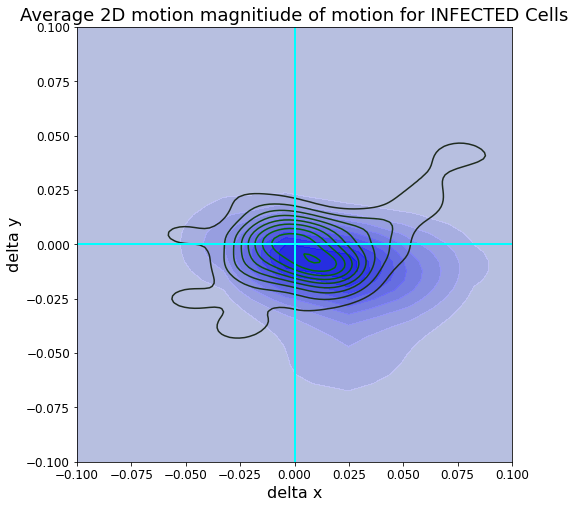

In [95]:

f, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")
ax.set_facecolor((0.4, 0.5, 0.6))
ax = sns.kdeplot(np.array(x_b), np.array(y_b), linestyles="solid",
                 color='g', shade=False, alpha=1)
ax = sns.kdeplot(np.array(x_a), np.array(y_a), linestyles="solid",
                 color='b', shade=True, alpha=.7)
ax.set_ylim(-.10, .10)
ax.set_xlim(-.10, .10)
ax.set_title(title1, size=18)
plt.axhline(0, color='cyan', linewidth=2)
plt.axvline(0, color='cyan', linewidth=2)
ax.set_xlabel('delta x', fontsize=16)
ax.set_ylabel('delta y', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.show()



As it is shown in above figure the total magnitude of myofibrilis motilities are more than the total magnitude of other cell's motilities.

In [96]:
print('Mean motility in x direction of myofibrilis cells: '+ str(np.mean(mdx2)) +' pixels per frame')
print('Mean motility in y direction of myofibrilis cells: '+ str(np.mean(mdy2)) +' pixels per frame')
print('Mean motility in x direction of other cells: '+ str(np.mean(mdx1)) +' pixels per frame')
print('Mean motility in y direction of other cells: '+ str(np.mean(mdy1)) +' pixels per frame')

Mean motility in x direction of myofibrilis cells: 0.0056343833 pixels per frame
Mean motility in y direction of myofibrilis cells: -0.004258581 pixels per frame
Mean motility in x direction of other cells: -0.008913105 pixels per frame
Mean motility in y direction of other cells: -0.019584669 pixels per frame


In [97]:
d_x1 = np.mean(mdx1)
d_y1 = np.mean(mdy1)

d_x2 = np.mean(mdx2)
d_y2 = np.mean(mdy2)

Mag_myofibrilis = np.sqrt(d_x1**2 + d_y1**2)
Mag_other = np.sqrt(d_x2**2 + d_y2**2)

Mag_myofibrilis, Mag_other

(0.021517497509266223, 0.007062703947131569)

Hence, the mean of motility magnitudes in myofibrilis cells is greater than infected ones. However, this is based on pixels. We had a resize from (1023x 1023) --> 400x400 ===> Rescale ratio = 1023x1023/400x400

In [98]:
ratio= (1023*1023)/(400*400)
ratio

6.54080625

Therefore, We need to multiply above numbers by that ratio and then convert the pixel space into metric space.

In [99]:
print('Total magnitude of myofibrilis motility per frame(nm):' + str(Mag_myofibrilis*ratio*100)) 
print('Total magnitude of other cells motility per frame(nm):' + str(Mag_other*ratio*100)) 

Total magnitude of myofibrilis motility per frame(nm):14.074178219296796
Total magnitude of other cells motility per frame(nm):4.619577811929784


fps = 100 ==> Average motility of myofibrilis = 0.14 nm/sec.

fps = 100 ==> Average motility of other cells = 0.046 nm/sec.